<a href="https://colab.research.google.com/github/nyc-pyladies/2019-cmdstanpy-bayesian-workshop/blob/master/BayesianWorkflowUsingCmdStanPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Bayesian Workflows with CmdStanPy:<br> 
  Predicting the Women's World Cup Outcomes</h1></center><br>
​
​
<center> <img src="https://image.cnbcfm.com/api/v1/image/106005733-1562521667231gettyimages-1154402796.jpeg?v=1562521711" alt="Womens world cup"> </center>
<center> <h2>#WeStan</h2></center>

​
<h2> Table of Contents:<a name="TOC"></a></h2>

- [0. On implementing a Bayesian Workflow](#Intro)
- [1. Installation and Importing Packages+Data](#IDA)
- [2. Stan Input](#StanInput)
- [3. Stan Model for the WWC 2019](#StanModel)
- [4. Model Interpretation](#Interpret)
- [5. Visualizations!](#Plots)
- [6.Predictions!](#Pred)

## 1. Installing CmdStanpy <a name="IDA"></a>

In [0]:
  # Clone directory and install cmdstan.
!pip install cmdstanpy
!git clone https://github.com/stan-dev/cmdstanpy.git
!python cmdstanpy/bin/install_cmdstan
!pip install ujson

fatal: destination path 'cmdstanpy' already exists and is not an empty directory.
CmdStan version: 2.20.0
Install directory: /root/.cmdstanpy
CmdStan version 2.20.0 already installed


In [0]:
import cmdstanpy
import pandas as pd
from cmdstanpy import Model, StanFit
import ujson as json

Getting the world cup data

In [0]:
!git clone https://github.com/nyc-pyladies/2019-cmdstanpy-bayesian-workshop

fatal: destination path '2019-cmdstanpy-bayesian-workshop' already exists and is not an empty directory.


In [0]:
!ls 2019-cmdstanpy-bayesian-workshop

data  models  notebooks  README.md


### We have two data files; The first one gives us information upto the quarterfinals:

In [0]:
matches = pd.read_csv('2019-cmdstanpy-bayesian-workshop/data/womens_world_cup_2019.csv')
matches.head()

,date,match_list,team_1,team_2,score_1,score_2
0,2019-06-07,France vs South Korea,France,South Korea,4.0,0.0
1,2019-06-08,Germany vs China,Germany,China,1.0,0.0
2,2019-06-08,Spain vs South Africa,Spain,South Africa,3.0,1.0
3,2019-06-08,Norway vs Nigeria,Norway,Nigeria,3.0,0.0
4,2019-06-09,Australia vs Italy,Australia,Italy,1.0,2.0


The second one is a list of the countries that participated in the decreasing order of "ability" prior to the tournament. 
This would be our **PRIOR** here.
We use the *soccer power index*, abbreviated here as "spi", as determined at [538 by Nate Silver](https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/). In the stan model, these feature as "prior_score" in the input and as "ability" in the model.

In [0]:
countries = pd.read_csv('2019-cmdstanpy-bayesian-workshop/data/country_prior.csv')
countries.head()

,country,spi
0,USA,97.20623
1,France,95.31747
2,Germany,94.17161
3,Australia,93.13200
4,Netherlands,92.70844


In [0]:
import numpy as np
mean = np.mean(countries['spi'])
std = np.std(countries['spi'])

#Rescaling the prior!
countries['prior_score'] = [(x - mean)/std for x in countries['spi']]

In [0]:
country_mapping = countries.country.to_dict()
country_mapping = {k:v+1 for v,k in country_mapping.items()}

## 2. Input the Data to CmdStanPy <a name="StanInput"></a>

The input data for the model needs to be in a dictionary format with the following keys: <br>

1. I: The number of teams <br>
2. N: The number of matches played <br>
3. team_1: A column of the "first" team <br>
4. team_2: A column of the "second" team <br>
5. score_1: Goals scored by the first team <br>
6. score_2: Goals scored by the second team <br>
7. prior_score: The countries' prior scores (i.e., spi's before the tournament) sorted in the descending order <br>

In [0]:
N = len(matches)
I = len(countries)
mydict = dict({'I': I,
               'N': N,
                'team_1': matches['team_1'].values,
               'team_2': matches['team_2'].values,
               'score_1': matches['score_1'].values,
               'score_2': matches['score_2'].values,
              'prior_score': countries['prior_score'].values})

We're now going to refer to the teams by a number that represents their pre-tournament ranking. To do that we first define a dictionary where the keys are the country names and the values are the team ranking.

In [0]:
#Replace team names by their rankings;

mydict['team_1'] = [ country_mapping.get(x) for x in mydict['team_1']]
mydict['team_2'] = [ country_mapping.get(x) for x in mydict['team_2']]

Our data is now prepped for Stan. We are ready to model it!

## 3. Stan Model for the Women's World Cup Data <a name="StanModel"></a>

This story is a long one and it can be as involved as you'd like it to be. The model we use here is based on a theory known as ["Item Response Theory"](https://mc-stan.org/docs/2_19/stan-users-guide/item-response-models-section.html) which says that the difference in the goals scored in a match should depend in some way on the difference in the "ability" between the teams. It's a simple but powerful idea that has an [applications](https://mc-stan.org/events/stancon2017-notebooks/stancon2017-groves-irt.html) in trying to predict the outcome of a task that inherently depends on how hard the task is and how "competent" the agent carrying out is. <br>

If you want to take a quick peek into the model, it's right [here](https://github.com/nyc-pyladies/2019-cmdstanpy-bayesian-workshop/blob/master/models/worldcup_rep_ag.stan)!

If you'd like to know more, read on! :) 

**1. Data**: <br>

In our specific case we have: <br>
(a) the goals scored in 48 matches (data) <br>
(b) the ability of each team prior to the tournament (prior) <br>

**2. Transformed Data**: <br>

At the end of the day, we care about predicting the "score differentials", i.e. the difference in goals scored between Team 1 and Team 2. <br>
The data is thus transformed into: <br>
$$y = score_1 - score_2$$ <br>
(Where $y > 0$, Team 1 won!)

**3. Parameters**: <br>

The "abilities" (i.e., soccer power index) we have disussed so far, are an attempt at quantifying our prior knowledge of the team's abilities. These must be updated as more games get played. Our model must be able to update these abilities based on what we can infer from the performance of the team. Our new "abilities" for each team 'i' would be: <br>

$$a_i = \beta \times \hbox{prior_score} + \sigma_a \times \alpha_i $$

We would like to infer the distributions of $\beta$ and $\alpha$ - we assume normal prior on both for starters.

**4. Model**: <br>

The model we have for the score differentials now is: <br>

$$y_i \sim t(df, a_j[teami] - a_i[team2], \sigma_y) $$,

where t is the ["student t distribution"](https://en.wikipedia.org/wiki/Student%27s_t-distribution).



In [0]:
stan_wc = Model(stan_file='2019-cmdstanpy-bayesian-workshop/models/worldcup_rep_ag.stan')
stan_wc.compile()
stan_wc

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /content/2019-cmdstanpy-bayesian-workshop/models/worldcup_rep_ag


Model(name=worldcup_rep_ag,  stan_file="2019-cmdstanpy-bayesian-workshop/models/worldcup_rep_ag.stan", exe_file="/content/2019-cmdstanpy-bayesian-workshop/models/worldcup_rep_ag")

We can now fit the model to the data!

In [0]:
worldcup_fit = stan_wc.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 4


It is important to make sure that there was "convergence":

In [0]:
worldcup_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /tmp/tmp6ly420rk/stan-worldcup_rep_ag-draws-1-edr_23xj.csv, /tmp/tmp6ly420rk/stan-worldcup_rep_ag-draws-2-i_tsjw4l.csv, /tmp/tmp6ly420rk/stan-worldcup_rep_ag-draws-3-00hwyuqv.csv, /tmp/tmp6ly420rk/stan-worldcup_rep_ag-draws-4-7s6l95f_.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

The Stanfit "summary" method gives us a peek into the distributions of all the parameters. CmdStanPy outputs the same as a pandas dataframe for downstream analysis:

In [0]:
df = worldcup_fit.summary().round(decimals = 2)
df

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-52.36,0.28,6.81,-64.38,-51.92,-42.08,573.02,625.17,1.0
beta,0.94,0.01,0.25,0.53,0.94,1.35,1788.73,1951.52,1.0
alpha[1],0.97,0.01,0.70,-0.16,0.97,2.10,3247.88,3543.47,1.0
alpha[2],0.32,0.01,0.63,-0.69,0.32,1.33,3735.26,4075.20,1.0
alpha[3],0.40,0.01,0.63,-0.67,0.41,1.39,3603.41,3931.36,1.0
alpha[4],-0.19,0.01,0.67,-1.27,-0.22,0.96,4808.89,5246.55,1.0
alpha[5],0.46,0.01,0.63,-0.56,0.47,1.45,3972.77,4334.34,1.0
alpha[6],0.53,0.01,0.72,-0.68,0.56,1.68,3634.16,3964.91,1.0
alpha[7],-0.78,0.01,0.72,-1.99,-0.75,0.35,3143.68,3429.79,1.0



What you see above above is a dataframe of the summary of the "stanfit" object:

From the Stan [documentation](https://mc-stan.org/rstan/reference/stanfit-class.html):<br>
An object of class stanfit contains the output derived from fitting a Stan model as returned by the top-level function stan or the lower-level methods sampling and vb (which are defined on class stanmodel). Many methods (e.g., print, plot, summary) are provided for summarizing results and various access methods also allow the underlying data (e.g., simulations, diagnostics) contained in the object to be retrieved.

The summary method returns a named list with elements summary and c_summary, which contain summaries for for all chains merged and individual chains, respectively. Included in the summaries are quantiles, means, standard deviations (sd), effective sample sizes (n_eff), and split Rhats (the potential scale reduction derived from all chains after splitting each chain in half and treating the halves as chains). For the summary of all chains merged, Monte Carlo standard errors (se_mean) are also reported.

## 4. Interpreting the Model Fit <a name="Interpret"></a>

In [0]:
dft = df.transpose()
ability_filter = [col for col in dft if col.startswith('ability')]
yrep_filter = [col for col in dft if col.startswith('y_rep')]

In [0]:
#Abilities
abilities = dft[ability_filter]
abilities

name,ability[1],ability[2],ability[3],ability[4],ability[5],ability[6],ability[7],ability[8],ability[9],ability[10],ability[11],ability[12],ability[13],ability[14],ability[15],ability[16],ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24]
Mean,2.01,1.27,1.30,0.68,1.27,1.38,0.16,0.67,0.60,1.02,0.42,-0.39,0.30,-0.05,-1.06,0.56,-0.61,-0.62,-1.38,-2.09,-0.85,-2.56,-1.11,-0.96
MCSE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.02
StdDev,0.62,0.54,0.55,0.61,0.56,0.63,0.59,0.57,0.58,0.57,0.56,0.66,0.57,0.58,0.81,0.63,0.64,0.58,0.63,0.77,0.74,0.77,0.66,0.88
5%,1.01,0.36,0.42,-0.31,0.39,0.41,-0.84,-0.25,-0.35,0.12,-0.51,-1.48,-0.66,-1.06,-2.44,-0.44,-1.70,-1.55,-2.42,-3.38,-2.00,-3.90,-2.17,-2.41
50%,2.01,1.27,1.29,0.68,1.27,1.34,0.16,0.67,0.61,1.01,0.41,-0.38,0.31,-0.02,-1.05,0.53,-0.58,-0.64,-1.37,-2.08,-0.89,-2.54,-1.13,-0.94
95%,3.06,2.17,2.20,1.67,2.21,2.45,1.11,1.61,1.54,1.95,1.38,0.64,1.23,0.88,0.22,1.62,0.40,0.36,-0.37,-0.88,0.42,-1.35,-0.01,0.47
N_Eff,2179.10,3980.45,3164.49,3821.90,3525.00,2595.35,3304.55,4303.59,3934.81,2798.12,4023.11,3030.90,4267.12,3630.69,1473.73,2326.45,3389.09,4316.58,3102.73,1596.71,1869.60,2320.57,3090.91,1438.19
N_Eff/s,2377.43,4342.72,3452.49,4169.73,3845.81,2831.55,3605.29,4695.26,4292.92,3052.77,4389.25,3306.74,4655.47,3961.12,1607.86,2538.18,3697.53,4709.43,3385.11,1742.02,2039.75,2531.76,3372.22,1569.08
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [0]:
#Team Differentials
td = dft[yrep_filter]
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],y_rep[11],y_rep[12],y_rep[13],y_rep[14],y_rep[15],y_rep[16],y_rep[17],y_rep[18],y_rep[19],y_rep[20],y_rep[21],y_rep[22],y_rep[23],y_rep[24],y_rep[25],y_rep[26],y_rep[27],y_rep[28],y_rep[29],y_rep[30],y_rep[31],y_rep[32],y_rep[33],y_rep[34],y_rep[35],y_rep[36],y_rep[37],y_rep[38],y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.32,1.35,1.78,0.94,0.13,2.67,2.22,-1.08,1.28,-1.71,-2.13,4.56,0.51,0.87,0.96,0.06,-1.33,1.01,-2.68,2.35,1.85,1.05,3.64,3.10,-0.48,-2.70,-1.87,-1.33,-0.05,-2.77,0.09,-1.23,-0.19,0.61,-0.99,-1.45,1.89,-0.37,1.95,0.71,-1.59,0.38,0.63,1.07,-1.06,-0.71,-0.70,0.30
MCSE,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.02,0.03,0.03,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02
StdDev,1.74,1.63,1.60,1.66,1.66,1.69,1.70,1.76,1.64,1.65,1.60,1.79,1.71,1.62,1.64,1.59,1.59,1.69,1.77,1.72,1.60,1.64,1.71,1.67,1.59,1.67,1.66,1.66,1.64,1.67,1.65,1.63,1.66,1.61,1.61,1.72,1.61,1.66,1.63,1.61,1.64,1.68,1.67,1.62,1.68,1.65,1.65,1.60
5%,-0.63,-1.26,-0.84,-1.70,-2.49,-0.08,-0.51,-4.09,-1.36,-4.33,-4.76,1.60,-2.24,-1.70,-1.71,-2.49,-3.91,-1.66,-5.45,-0.35,-0.72,-1.62,0.86,0.47,-3.04,-5.31,-4.56,-3.98,-2.74,-5.35,-2.55,-3.79,-2.89,-2.02,-3.62,-4.19,-0.80,-3.05,-0.66,-1.90,-4.22,-2.32,-2.08,-1.58,-3.70,-3.27,-3.40,-2.31
50%,2.37,1.35,1.80,0.92,0.06,2.68,2.22,-1.02,1.27,-1.73,-2.16,4.62,0.50,0.86,0.95,0.07,-1.34,0.99,-2.73,2.30,1.87,1.07,3.62,3.11,-0.49,-2.72,-1.87,-1.36,-0.02,-2.77,0.06,-1.28,-0.17,0.63,-0.99,-1.49,1.91,-0.33,1.96,0.74,-1.63,0.41,0.65,1.09,-1.09,-0.73,-0.73,0.33
95%,4.98,3.88,4.28,3.62,2.89,5.41,4.95,1.71,3.89,1.05,0.43,7.44,3.21,3.44,3.57,2.63,1.25,3.81,0.26,5.16,4.35,3.67,6.41,5.76,2.15,0.05,0.80,1.43,2.49,-0.06,2.75,1.49,2.39,3.17,1.59,1.40,4.43,2.32,4.56,3.36,1.05,3.00,3.29,3.63,1.77,1.97,1.90,2.84
N_Eff,3001.39,3574.21,3940.48,4285.55,2801.54,4450.74,4062.86,3071.81,4289.92,3593.31,4256.76,2878.63,3947.27,4133.53,3843.89,4478.14,4219.65,3208.76,2656.45,3197.21,4331.78,4103.14,3396.92,4400.77,3727.14,3896.48,4212.58,3404.29,3591.98,3909.78,3740.09,3781.51,3338.63,4069.48,3862.14,2634.22,3584.11,4283.37,4333.42,4287.38,3661.64,2964.97,3817.53,3788.99,3591.89,3948.23,4320.82,4555.18
N_Eff/s,3274.55,3899.50,4299.10,4675.57,3056.51,4855.80,4432.62,3351.37,4680.35,3920.33,4644.16,3140.62,4306.51,4509.72,4193.72,4885.70,4603.68,3500.79,2898.22,3488.19,4726.02,4476.57,3706.07,4801.29,4066.35,4251.09,4595.97,3714.12,3918.88,4265.61,4080.48,4125.67,3642.48,4439.84,4213.63,2873.96,3910.30,4673.20,4727.81,4677.58,3994.89,3234.81,4164.97,4133.82,3918.79,4307.55,4714.06,4969.74
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## 5. Let's Make Some Plots!<a name="Plots"></a> 

In [0]:
import matplotlib.pyplot as plt
df_teamdifferentials = pd.DataFrame({'midway': td.loc['50%'].values,
                                       'names':matches['match_list']})
df_teamdifferentials.loc[:, 'left'] = td.loc['5%'].values
df_teamdifferentials.loc[:, 'right'] = td.loc['95%'].values

In [0]:
actual_differentials = np.array([matches['score_1'][i]-matches['score_2'][i]  for i in range(len(matches))])

In [0]:
cd 2019-cmdstanpy-bayesian-workshop/notebooks

/content/2019-cmdstanpy-bayesian-workshop/notebooks


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


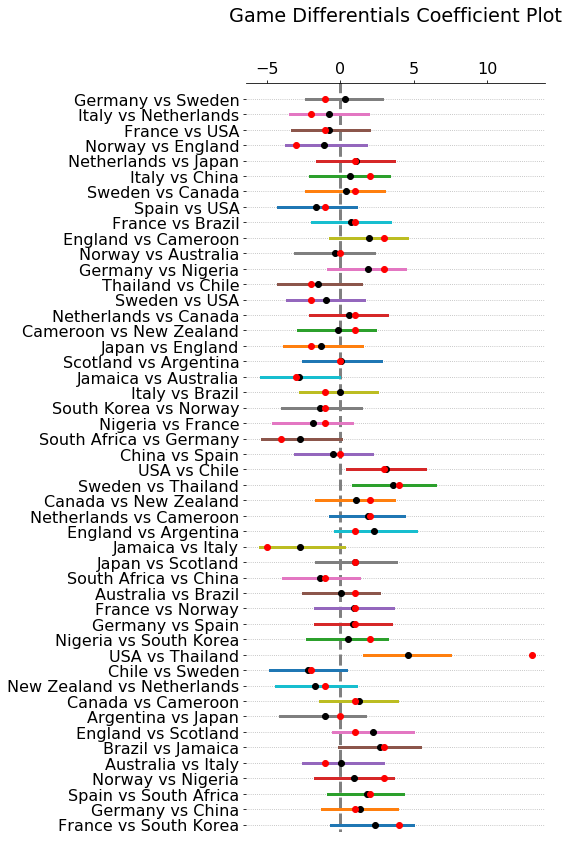

In [0]:
from coefplot import coefficient_plot

coefficient_plot(df_teamdifferentials['midway'], df_teamdifferentials['left'], 
                 df_teamdifferentials['right'], actual_differentials, 
                 names=df_teamdifferentials['names'],
                 title='Game Differentials Coefficient Plot')
plt.tight_layout()

In [0]:
df_abilities = pd.DataFrame({'midway': abilities.loc['50%'].values,
                                       'names': countries['country']})
df_abilities.loc[:, 'left'] = abilities.loc['5%'].values
df_abilities.loc[:, 'right'] = abilities.loc['95%'].values

In [0]:
coefficient_plot(df_abilities['midway'], df_abilities['left'], 
                 df_abilities['right'], countries['prior_score'], 
                 names=df_abilities['names'],
                 title='Abilities Coefficient Plot')
plt.tight_layout()

## 6. Let's Make Some Predictions! <a name="Pred"></a>